In [33]:
import torch
import torch.nn as nn
import torch.optim as optim

# XOR input and output
inputs = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
outputs = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(2, 2)  # 2 input features to 2 hidden nodes
        self.output = nn.Linear(2, 1)   # 2 hidden nodes to 1 output node
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.hidden1(x))
        y = self.sigmoid(self.output(x))
        return x, y

# Function to compute Rayleigh quotient
def compute_rayleigh_quotient(w, cov_mat):
    w = w.unsqueeze(1)
    numerator = torch.mm(torch.mm(w.T, cov_mat), w)
    denominator = torch.mm(w.T, w) * torch.trace(cov_mat)
    return (numerator / denominator).item()

score = 0
model = MLP()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Store Rayleigh quotients
rayleigh_quotients_fc1 = [[] for _ in range(2)]
rayleigh_quotients_fc2 = []

# Training process
epochs = 30000
for epoch in range(epochs):
    # Forward pass
    hidden_output, predicted_output = model(inputs)
    loss = criterion(predicted_output, outputs)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Compute Rayleigh quotients every 1000 epochs
    if epoch % 1000 == 0:
        with torch.no_grad():
            # Compute input covariance matrix
            input_cov_mat = torch.cov(inputs.T)

            # Compute Rayleigh quotients for fc1 (hidden layer)
            for i in range(2):
                w = model.hidden1.weight[i, :]
                rq = compute_rayleigh_quotient(w, input_cov_mat)
                rayleigh_quotients_fc1[i].append(rq)

            # Compute Rayleigh quotient for fc2 (output layer)
            hidden_cov_mat = torch.cov(hidden_output.T)
            w = model.output.weight.squeeze()
            rq = compute_rayleigh_quotient(w, hidden_cov_mat)
            rayleigh_quotients_fc2.append(rq)

# Print final predictions and Rayleigh quotients
print("Final predictions:")
with torch.no_grad():
    _, final_output = model(inputs)
    print(final_output)

print("Final Rayleigh quotients for fc1 (hidden layer):")
for i, rq_list in enumerate(rayleigh_quotients_fc1):
    print(f"Node {i+1}: {rq_list[-1]}")

print("Final Rayleigh quotient for fc2 (output layer):")
print(rayleigh_quotients_fc2[-1])

rounded_output = torch.round(final_output)
expected_output = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)
score += (torch.sum(rounded_output == expected_output).item()) / 4

print(f"Final score: {score}")

Final predictions:
tensor([[0.0365],
        [0.9659],
        [0.9586],
        [0.0322]])
Final Rayleigh quotients for fc1 (hidden layer):
Node 1: 0.5
Node 2: 0.5
Final Rayleigh quotient for fc2 (output layer):
0.2813446521759033
Final score: 1.0


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

def create_jittered_dataset(n_samples=1000, noise_std=0.1):
    X_base = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
    Y_base = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)
    
    X = torch.zeros((n_samples, 2), dtype=torch.float32)
    Y = torch.zeros((n_samples, 1), dtype=torch.float32)
    
    for i in range(n_samples):
        idx = i % 4
        X[i] = X_base[idx] + torch.randn(2) * noise_std
        Y[i] = Y_base[idx]
    
    return X, Y

class XORModel(nn.Module):
    def __init__(self):
        super(XORModel, self).__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 1)

    def forward(self, x):
        x1 = torch.sigmoid(self.fc1(x))
        x2 = torch.sigmoid(self.fc2(x1))
        return x1, x2

def train_model(X, Y):
    model = XORModel()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(30000):
        model.train()
        optimizer.zero_grad()
        _, outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

    return loss.item()

# Run the training process 50 times
num_runs = 50
final_losses = []

for run in range(num_runs):
    X, Y = create_jittered_dataset()
    final_loss = train_model(X, Y)
    final_losses.append(final_loss)
    print(f"Run {run + 1}: Final Loss = {final_loss:.6f}")

# Report the highest loss
highest_loss = max(final_losses)
print(f"\nHighest Final Loss: {highest_loss:.6f}")

# Additional statistics
average_loss = sum(final_losses) / len(final_losses)
min_loss = min(final_losses)

print(f"Average Final Loss: {average_loss:.6f}")
print(f"Minimum Final Loss: {min_loss:.6f}")
print(f"Range of Final Losses: {highest_loss - min_loss:.6f}")

Run 1: Final Loss = 0.000000
Run 2: Final Loss = 0.000000
Run 3: Final Loss = 0.346574
Run 4: Final Loss = 0.000000
Run 5: Final Loss = 0.346574
Run 6: Final Loss = 0.000000
Run 7: Final Loss = 0.000000
Run 8: Final Loss = 0.000000
Run 9: Final Loss = 0.477386
Run 10: Final Loss = 0.000000
Run 11: Final Loss = 0.000000
Run 12: Final Loss = 0.346574
Run 13: Final Loss = 0.346574
Run 14: Final Loss = 0.346574
Run 15: Final Loss = 0.346574
Run 16: Final Loss = 0.346574
Run 17: Final Loss = 0.000000
Run 18: Final Loss = 0.477386
Run 19: Final Loss = 0.000000
Run 20: Final Loss = 0.346574
Run 21: Final Loss = 0.000000
Run 22: Final Loss = 0.000000
Run 23: Final Loss = 0.346574
Run 24: Final Loss = 0.002625
Run 25: Final Loss = 0.346574
Run 26: Final Loss = 0.000000
Run 27: Final Loss = 0.478483
Run 28: Final Loss = 0.346574
Run 29: Final Loss = 0.346574
Run 30: Final Loss = 0.000000
Run 31: Final Loss = 0.000000
Run 32: Final Loss = 0.346574
Run 33: Final Loss = 0.346574
Run 34: Final Loss 

In [38]:
print(rayleigh_quotients_fc1)


[[0.5, 0.5, 0.4999999701976776, 0.5, 0.5, 0.5000000596046448, 0.5000000596046448, 0.5, 0.5, 0.4999999701976776, 0.5, 0.4999999701976776, 0.4999999701976776, 0.5000000596046448, 0.5, 0.5, 0.5000000596046448, 0.5000000596046448, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5000000596046448, 0.5, 0.5], [0.5000000596046448, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5000000596046448, 0.5, 0.5, 0.5, 0.4999999701976776, 0.5000000596046448, 0.4999999701976776, 0.5, 0.5000000596046448, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.4999999403953552, 0.4999999403953552, 0.5, 0.5, 0.5, 0.5]]


In [43]:
print(rayleigh_quotients_fc2)


[0.16888755559921265, 0.08984879404306412, 0.05903512239456177, 0.04969494417309761, 0.0580761581659317, 0.08475899696350098, 0.13053055107593536, 0.1889411360025406, 0.2228562831878662, 0.2393212765455246, 0.24877433478832245, 0.25498345494270325, 0.2594394087791443, 0.262834757566452, 0.26553478837013245, 0.2677508294582367, 0.26961418986320496, 0.27121156454086304, 0.2726021707057953, 0.2738281190395355, 0.274920791387558, 0.27590346336364746, 0.2767937481403351, 0.27760621905326843, 0.2783517837524414, 0.2790397107601166, 0.2796775698661804, 0.28027063608169556, 0.2808249592781067, 0.2813446521759033]


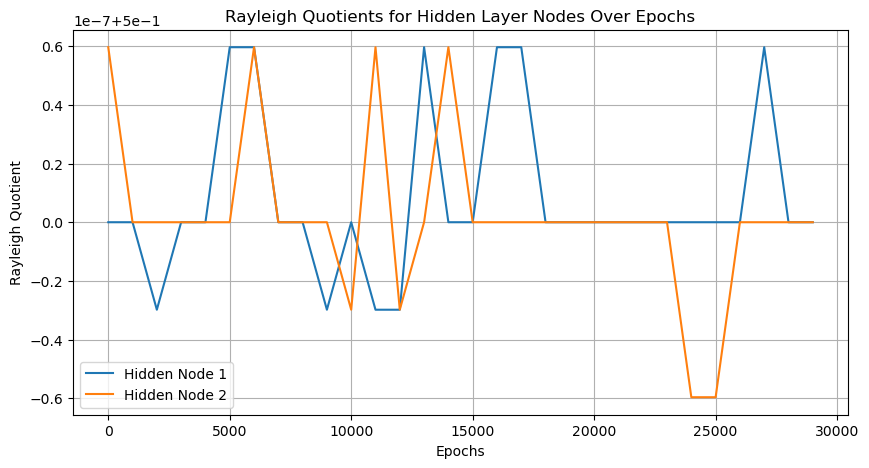

In [44]:
import matplotlib.pyplot as plt
epochs_recorded = list(range(0, 30000, 1000))

# Plot Rayleigh quotients for fc1 (hidden layer)
plt.figure(figsize=(10, 5))
for i in range(2):
    plt.plot(epochs_recorded, rayleigh_quotients_fc1[i], label=f'Hidden Node {i+1}')

plt.xlabel('Epochs')
plt.ylabel('Rayleigh Quotient')
plt.title('Rayleigh Quotients for Hidden Layer Nodes Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [2]:
print(rayleigh_quotients_fc1)


[[0.5, 0.5, 0.5000000596046448, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.4999999701976776, 0.5000000596046448, 0.5000000596046448, 0.5, 0.4999999701976776, 0.5000000596046448, 0.5, 0.4999999701976776, 0.5000000596046448, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.4999999701976776, 0.5, 0.5, 0.4999999701976776, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.4999999701976776, 0.5, 0.5000000596046448, 0.5, 0.4999999403953552, 0.5, 0.5, 0.5000000596046448, 0.5, 0.5, 0.4999999701976776, 0.5, 0.4999999701976776, 0.5, 0.5000000596046448, 0.5000000596046448, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5, 0.5000000596046448, 0.5, 0.49999991059303284, 0.5, 0.5, 0.5000000596046448, 0.5000000596046448, 0.5000000596046448, 0.4999999701976776, 0.5, 0.5, 0.5, 0.4999999701976776, 0.5000000596046448, 0.5000000596046448, 0.5]]


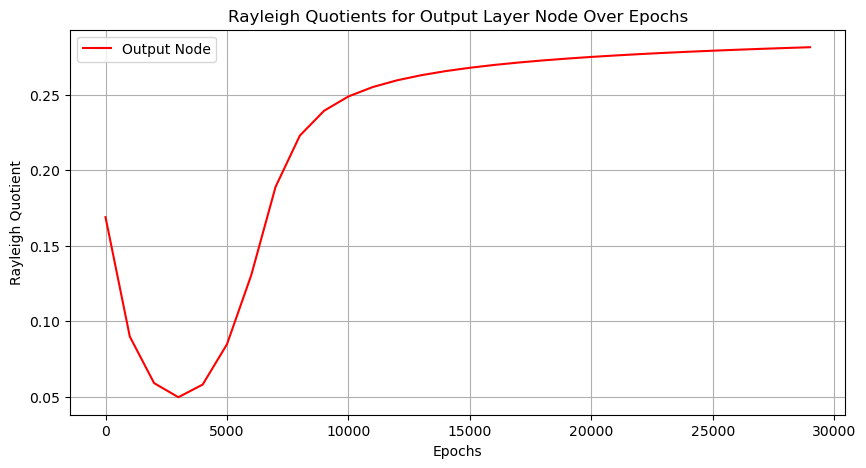

In [45]:
# Plot Rayleigh quotients for fc2 (output layer)
plt.figure(figsize=(10, 5))
plt.plot(epochs_recorded, rayleigh_quotients_fc2, label='Output Node', color='r')

plt.xlabel('Epochs')
plt.ylabel('Rayleigh Quotient')
plt.title('Rayleigh Quotients for Output Layer Node Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

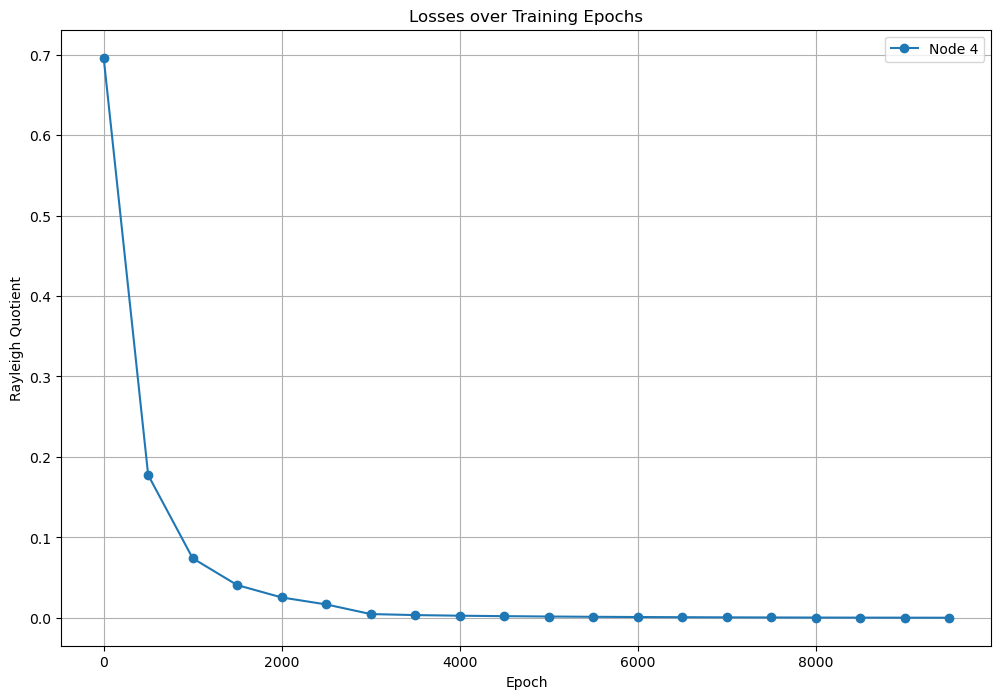

In [9]:
import matplotlib.pyplot as plt


epochs = list(range(0, 10000, 500))  # Since you're recording every 500 epochs up to 10000

plt.figure(figsize=(12, 8))
plt.plot(epochs, losses, marker='o', linestyle='-', label=f'Node {i + 1}')

plt.title('Losses over Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Rayleigh Quotient')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
losses

[array(0.6974676, dtype=float32),
 array(0.12284509, dtype=float32),
 array(0.04368497, dtype=float32),
 array(0.02265617, dtype=float32),
 array(0.01369413, dtype=float32),
 array(0.0089924, dtype=float32),
 array(0.00621367, dtype=float32),
 array(0.00444069, dtype=float32),
 array(0.00324852, dtype=float32),
 array(0.00241636, dtype=float32),
 array(0.00181938, dtype=float32),
 array(0.00138237, dtype=float32),
 array(0.00105743, dtype=float32),
 array(0.00081306, dtype=float32),
 array(0.00062759, dtype=float32),
 array(0.0004859, dtype=float32),
 array(0.00037705, dtype=float32),
 array(0.00029311, dtype=float32),
 array(0.00022816, dtype=float32),
 array(0.0001778, dtype=float32)]

In [69]:
x = torch.tensor([[0,0],
     [0,1],
     [1,0],
     [1,1]])
x_transpose = x.T

In [70]:
torch.mm(x_transpose, x) / (x.shape[0] - 1)

tensor([[0.6667, 0.3333],
        [0.3333, 0.6667]])

In [71]:
torch.cov(x_transpose)

tensor([[0.3333, 0.0000],
        [0.0000, 0.3333]])

In [72]:
# Transpose the data to have variables in columns
x_transpose = x.T

# Calculate the covariance matrix using torch.cov()
cov_matrix_from_cov = torch.cov(x_transpose)

# Calculate the covariance matrix using torch.mm() and scale
scaled_cov_matrix = torch.mm(x_transpose, x) / (x.shape[0] - 1)

In [73]:
cov_matrix_from_cov

tensor([[0.3333, 0.0000],
        [0.0000, 0.3333]])

In [74]:
scaled_cov_matrix

tensor([[0.6667, 0.3333],
        [0.3333, 0.6667]])

In [83]:
centered_x = torch.tensor([[-.5,-.5],
     [-.5,.5],
     [.5,-.5],
     [.5,.5]])
cov_matrix = torch.mm(centered_x.T,centered_x)/(x.shape[0]-1)


In [84]:
cov_matrix

tensor([[0.3333, 0.0000],
        [0.0000, 0.3333]])

In [113]:
weight = torch.tensor([[1],
                       [2]])
result = torch.mm(weight.T, weight)
print(result)

tensor([[5]])


In [112]:
result_2 = torch.sum(weight * weight)
print(result_2)


tensor(5)


In [ ]:
X = [[a_1,a_2,a_3,a_4,a_5],[b_1,b_2,b_3,b_4,b_5]]
180*5

[2*4] * [4*2] = 2*2 cov matrix, how the columns vary
[0,0]
[0,1]
[1,0]
[1,1]
[[1/3, 0],
 [0, 1/3]]

In [127]:
covariance_mat = cov_matrix
w = torch.tensor([[.6],[-10.7]])
numerator = torch.mm(torch.mm(w.T, covariance_mat), w)
denominator = torch.mm(w.T, w) * torch.trace(covariance_mat)
print(torch.trace(covariance_mat))
print("numerator:" + str(numerator))
print("denominator:" + str(denominator))
rq = (numerator / denominator).item()
print(numerator/denominator,rq)
print(f"Node {i + 1} in fc1, Rayleigh Quotient: {rq}")
print(f"weights: {w.T}")
rayleigh_quotients_fc1[i].append(rq)

tensor(0.6667)
numerator:tensor([[38.2833]])
denominator:tensor([[76.5667]])
tensor([[0.5000]]) 0.4999999403953552
Node 4 in fc1, Rayleigh Quotient: 0.4999999403953552
weights: tensor([[  0.6000, -10.7000]])


In [122]:
torch.mm(w.T, w)

tensor([[0.4194]])

In [ ]:
# Zero covariance is 0.5 Rayleigh quotient no matter the weights, can't capture
# 1 is maximized, 0 is minimized(smallest eigenvector). 

In [132]:
print(torch.sigmoid(torch.tensor(0)))
print(torch.sigmoid(torch.tensor(-0.24)))
print(torch.sigmoid(torch.tensor(-0.37)))
print(torch.sigmoid(torch.tensor(-0.61)))

tensor(0.5000)
tensor(0.4403)
tensor(0.4085)
tensor(0.3521)


In [137]:
torch.var(torch.tensor([[0.5000,0.4403,0.4085,0.3521]]))

tensor(0.0038)

In [20]:
import torch
#PCA Matrix Multiplication
#taking the [math,english,arts] scores for students and reducing 
#to two dimensions instead of 3, ignore y_train, labels could be like what school they are from
matrix1 = torch.tensor([[90,60,90],
                 [90,90,30],
                 [60,60,60],
                 [60,60,90],
                 [30,30,30]], dtype=torch.float)
#top 2 eigenvectors corresponding to the greatest eigenvalues
eigenvector_matrix = torch.tensor([[1.05594,-0.50494],
                                  [0.69108,-0.67548],
                                  [1,1]], dtype=torch.float)
# print(matrix1.shape)
centered_matrix = matrix1 - torch.mean(matrix1, dim=0)
print(torch.matmul(centered_matrix,eigenvector_matrix))

tensor([[ 55.3426,  17.8814],
        [ 16.0750, -62.3830],
        [ -6.3356,   3.0296],
        [ 23.6644,  33.0296],
        [-88.7462,   8.4422]])
